# Supply Chain Data Analytics

Analyzing and Forcasting Supermarket Sales

Stan Brouwer (Vrije Universiteit)  
Liz Chan (Master TSCM)  
Maaike Lamberst (Supply Chain Data analysis)  
Niek Schroor (Group 10)  
December 5, 2024

Introduction

We analyze, forecast and interpret the [Superstore sales](https://public.tableau.com/app/sample-data/sample_-_superstore.xls) provided by [Tableau](https://public.tableau.com/app/learn/sample-data) using different statistical and machine learning methods.

We describe our work in the PDF version. However, we would like to recommend reading our quarto manuscript *here* as it contains the **relevant** R code in the Article Notebook.

## Data Pre-processing

The superstore data set we selected is of high quality. Thus we do the required data pre-processing, but included the hypothetical steps we would take were our data of lower quality to communicate our understanding of the data pre-processing process.

We took the following pre-processing steps:

In [ ]:
# Clear workspace
rm(list = ls())
# Function to load (and install if necessary) dependencies
install_and_load <- function(packages) {
  install.packages(setdiff(packages, rownames(installed.packages())), dependencies = TRUE)
  invisible(lapply(packages, require, character.only = TRUE))
}
install_and_load(c("tidyverse", "readxl", "ggplot2", "lubridate", "stats", "Amelia","forecast", "tseries", "plotly", "stringr", "knitr"))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: Amelia

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.8.3, built: 2024-11-07)
## Copyright (C) 2005-2024 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: tseries

Loading required package: plotly

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: knitr

-   Improved column names by removing whitespaces
-   Removed the <code>Row_ID</code> column as it can be inferred by it’s index
-   Removed all columns with a single unique value, as storing these would be [redundant](https://few.vu.nl/~molenaar/courses/StatR/chapters/B-06-raw_data.html)
-   Ensured machine-readable date formats in yyyy-mm-dd as these usually differ per locale.
-   Ensured proper decimal separators
-   Calculated the number of missing values (both NA and empty string ““) per column.

In [ ]:
# Load the data
suppressWarnings({data <- read_excel("data/sample_-_superstore.xls")}) # The Postal code column is stored as 'text' but coerced to numeric, causing warnings which we suppress

# Improve column names (replace " "with "_")
colnames(data) <- str_replace_all(colnames(data), " ", "_")

# Remove the 'Row_ID' column as it can be inferred by it's index
data <- subset(data, select = -`Row_ID`)

# Remove all columns that have only one unique value, as storing these would be redundant
data <- data[, sapply(data, function(col) length(unique(col)) > 1)]

# Ensure a machine-readable date format as these are usually horrible in excel files
data$Order_Date <- as.Date(data$Order_Date, format = "%Y-%m-%d")
data$Ship_Date <- as.Date(data$Ship_Date, format = "%Y-%m-%d")

# The readxl package by default uses the correct decimal separator (as opposed to base R)

# Calculate the number of missing values per column.
# Origional dates and R date objects are in unix time, which return NA when compared to text (empty string). These dates are stored as 'double' datatype, Thus we check character columns for empty strings, and all columns for NA values. 
missing_values <- sapply(data, function(col) {
  if (inherits(col, "Date")) {
    sum(is.na(col))
  } else if (is.character(col)) {
    sum(is.na(col) | col == "")
  } else {
    sum(is.na(col))
  }
})


if (sum(missing_values) == 0) {
  print("None of the columns contains missing values") # We print to enforce the "Source: Article notebook
  } else {
  print("Some columns contain missing values")
}

[1] "None of the columns contains missing values"

Warning in rm(missing_value, missing_values_table): object 'missing_value' not
found

After these steps (and transposing the table for better document formatting), the data looks as follows:

In [ ]:
kable(t(head(data, 3)), caption = "First 5 Rows of the Data (Transposed)", format = "markdown")

  --------------- ----------------- ------------------------- ------------------------
  Order_ID        CA-2016-152156    CA-2016-152156            CA-2016-138688

  Order_Date      2016-11-08        2016-11-08                2016-06-12

  Ship_Date       2016-11-11        2016-11-11                2016-06-16

  Ship_Mode       Second Class      Second Class              Second Class

  Customer_ID     CG-12520          CG-12520                  DV-13045

  Customer_Name   Claire Gute       Claire Gute               Darrin Van Huff

  Segment         Consumer          Consumer                  Corporate

  City            Henderson         Henderson                 Los Angeles

  State           Kentucky          Kentucky                  California

  Postal_Code     42420             42420                     90036

  Region          South             South                     West

  Product_ID      FUR-BO-10001798   FUR-CH-10000454           OFF-LA-10000240

  Category        Furniture         Furniture                 Office Supplies

  Sub-Category    Bookcases         Chairs                    Labels

  Product_Name    Bush Somerset     Hon Deluxe Fabric         Self-Adhesive Address
                  Collection        Upholstered Stacking      Labels for Typewriters
                  Bookcase          Chairs, Rounded Back      by Universal

  Sales           261.96            731.94                    14.62

  Quantity        2                 3                         2

  Discount        0                 0                         0

  Profit          41.9136           219.5820                  6.8714
  --------------- ----------------- ------------------------- ------------------------

  : First 5 Rows of the Data (Transposed)


There is some more processing to do, for instance the removing of outliers. However, by doing so we impose our own assumptions on the data. Let’s start by evaluating the descriptive statistics of our data and check if further processing is required.

In [ ]:
descriptive_statistics <- function(column) {
  if (is.numeric(column)) {
    stats <- list(
      Min = min(column, na.rm = TRUE), # Note that handling NA values increases robustness (and I copied the funciton from some of my earlier work)
      Max = max(column, na.rm = TRUE),
      Mean = mean(column, na.rm = TRUE),
      Median = median(column, na.rm = TRUE),
      StdDev = sd(column, na.rm = TRUE)
    )
  } else if (inherits(column, "Date")) {
    stats <- list(
      Earliest = format(min(column, na.rm = TRUE), "%Y-%m-%d"),
      Latest = format(max(column, na.rm = TRUE), "%Y-%m-%d")
    )
  } else if (is.character(column)) {
    stats <- list(
      Unique = length(unique(column)),
      Mode = names(sort(table(column), decreasing = TRUE)[1])
    )
  } else {
    stats <- NULL
  }
  return(stats)
}

# Call function on dataframe
descriptive_stats <- lapply(data, descriptive_statistics)

# Separate to tables dependent on data type
numeric_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (is.numeric(data[[col_name]])) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)
date_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (inherits(data[[col_name]], "Date")) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)
character_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (is.character(data[[col_name]])) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)

# Output tables
kable(
  numeric_stats,
  caption = "Descriptive Statistics for Numeric Columns",
  format = "pipe")

  Column        Min         Max        Mean        Median    StdDev
  ------------- ----------- ---------- ----------- --------- ----------
  Postal_Code   1040        99301      55190.38    56430.5   32063.69
  Sales         0.444       22638.48   229.858     54.49     623.2451
  Quantity      1           14         3.789574    3         2.22511
  Discount      0           0.8        0.1562027   0.2       0.206452
  Profit        -6599.978   8399.976   28.6569     8.6665    234.2601

  : Descriptive Statistics for Numeric Columns


  Column       Earliest     Latest
  ------------ ------------ ------------
  Order_Date   2014-01-03   2017-12-30
  Ship_Date    2014-01-07   2018-01-05

  : Descriptive Statistics for Date Columns


We inspected the orders with the lowest and highers price (<code>Sales</code> in USD). The most expensive orders were professional printers, camera’s and teleconferencing units with high unit prices, and these orders often were of high <code>Quantity</code>. The orders with the lowest price where often binders, had a high <code>Discount</code> rate, and often a <code>Quantity</code> of just one.

We were fascinated by the orders with a negative <code>profit</code>. These all had high <code>Discount</code> rates, and often concerned the same items, such as the <code>Cubify CubeX 3D Printer Triple Head Print</code>. The orders with a negative <code>Profit</code> where often part of a larger order (for instance <code>CA-2016-108196</code>), and placed by customers that placed multiple orders. We suspect these negative <code>Profit</code>’s to be caused by faulty items that receive discounts, general discount codes, or volumne discounts. However, due to especially the high discounts on orders with negative profits, we assume these to be valid orders. This decision has also been influenced by the high quality of the data. As we found no missing values whatshowever, we suspect the chance of some weird but valid orders to be higher than encountering mistakes here. *\[this paragraph could use some rewriting\]*

## Data Visualization

# A tibble: 20 × 3
   Product_Name                                         total_quantity ProdName8
   <chr>                                                         <dbl> <chr>    
 1 Staples                                                         215 "Staples"
 2 Staple envelope                                                 170 "Staple …
 3 Easy-staple paper                                               150 "Easy-st…
 4 Staples in misc. colors                                          86 "Staples…
 5 KI Adjustable-Height Table                                       74 "KI Adju…
 6 Avery Non-Stick Binders                                          71 "Avery N…
 7 Storex Dura Pro Binders                                          71 "Storex …
 8 GBC Premium Transparent Covers with Diagonal Lined …             67 "GBC Pre…
 9 Situations Contoured Folding Chairs, 4/Set                       64 "Situati…
10 Staple-based wall hangings                                       62 "Staple-…
11 Chromc

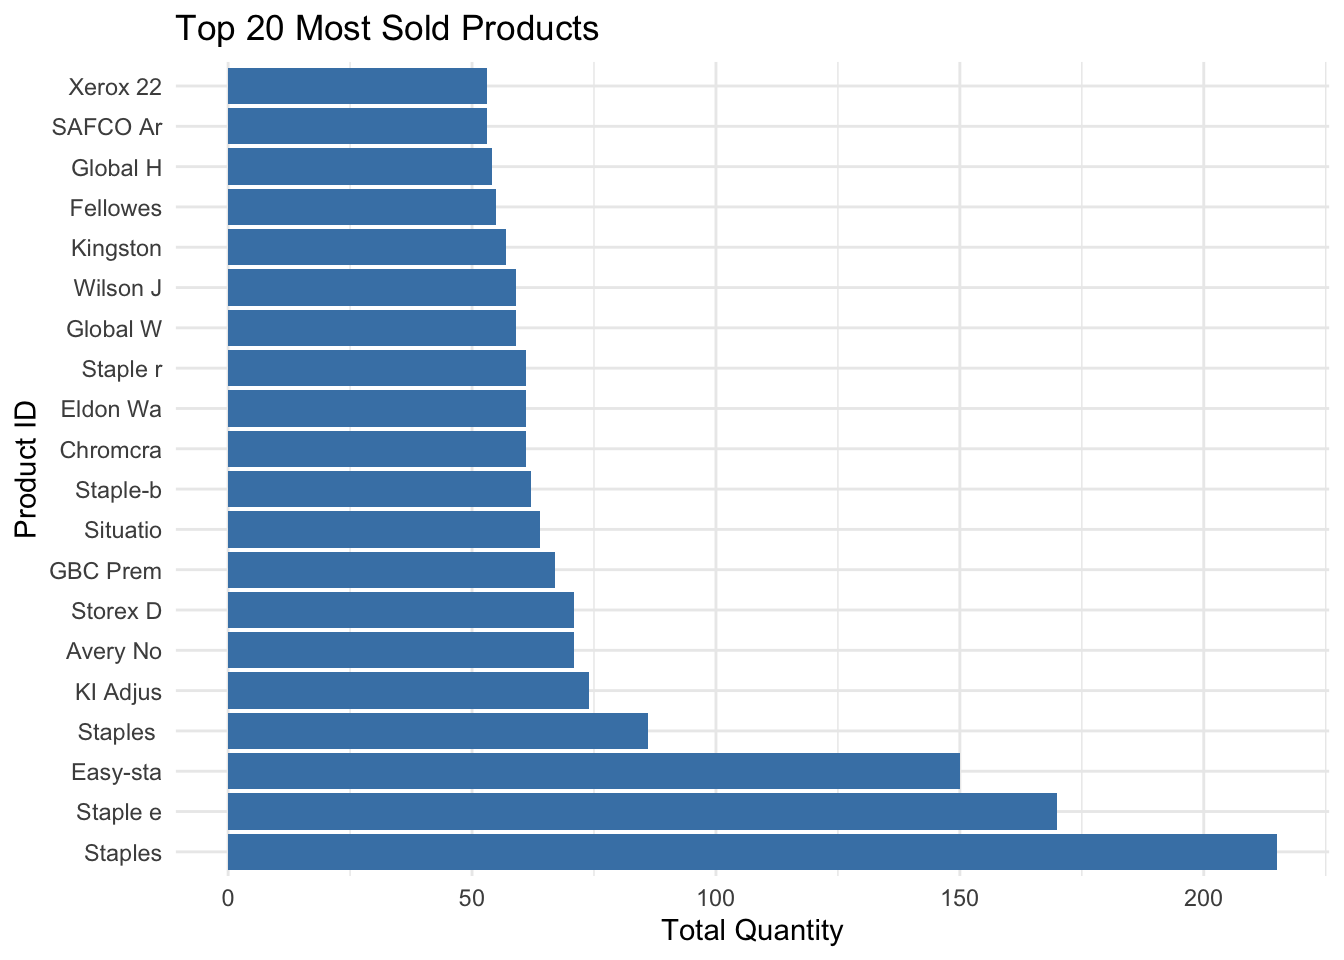

`summarise()` has grouped output by 'Product_Name'. You can override using the
`.groups` argument.

ℹ Please use `linewidth` instead.

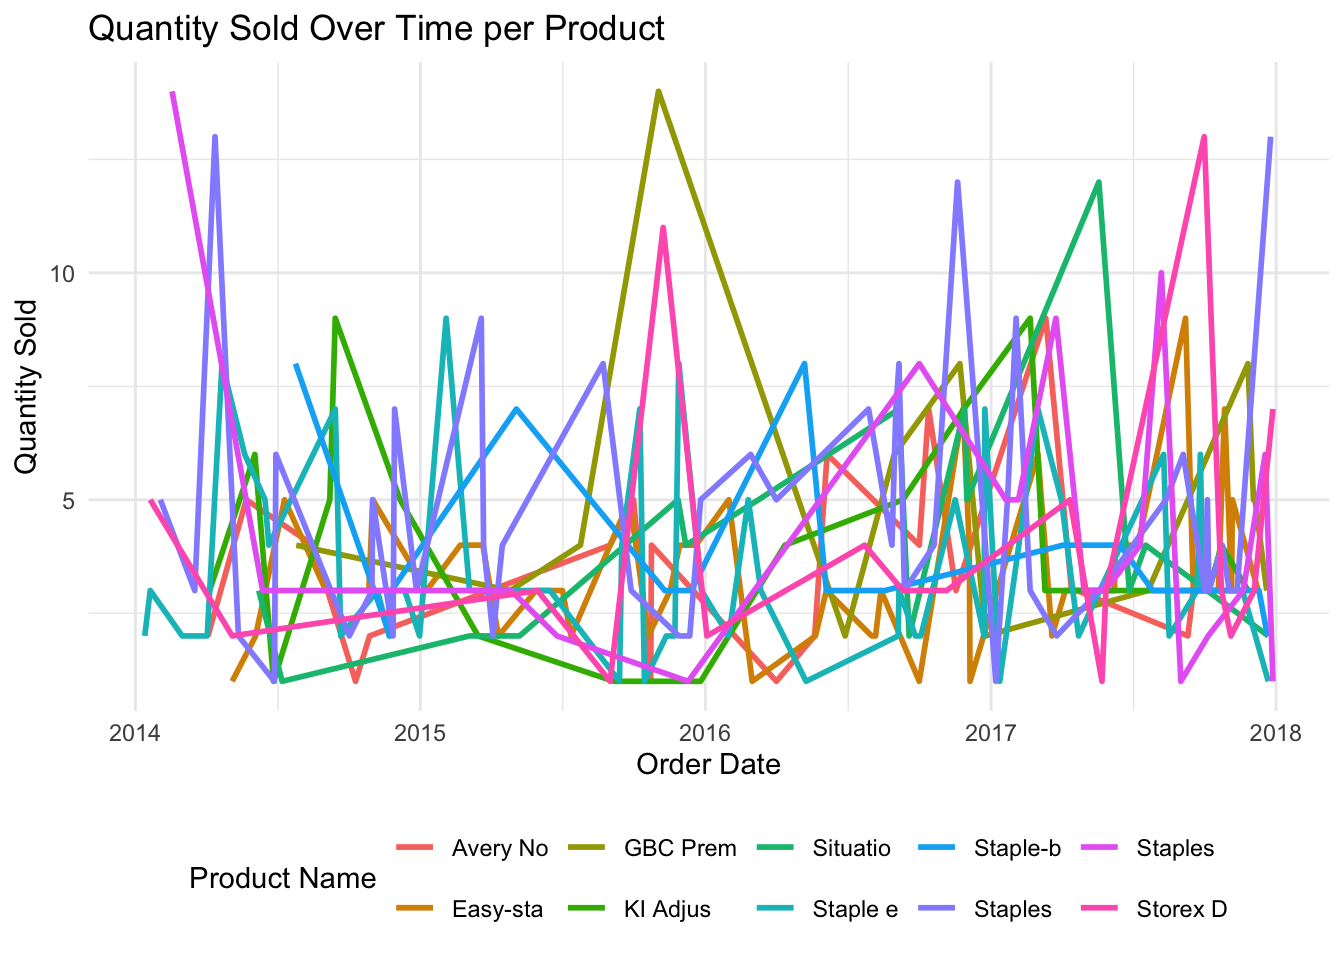

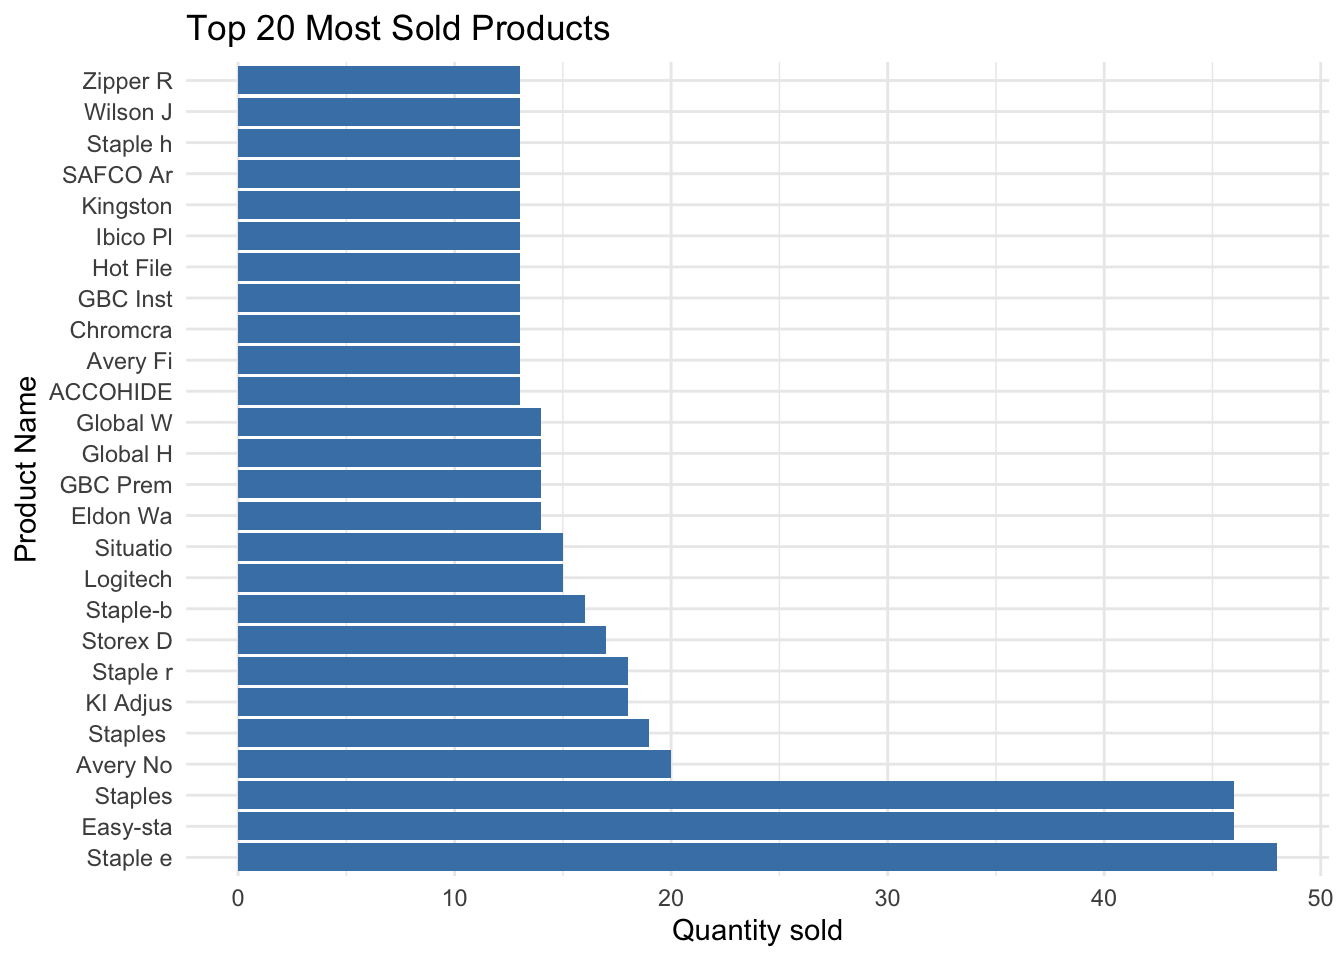

In [ ]:
# Sum of Quantity for top products
top_products <- data %>%
  group_by(Product_Name) %>%
  summarize(total_quantity = sum(Quantity, na.rm = TRUE)) %>%
  arrange(desc(total_quantity)) %>%
  slice_head(n = 20) %>%  # Top 20 products
  mutate(ProdName8 = substr(Product_Name, 1, 8)) # Truncate product names to the first 8 characters

# View the result
top_products

This is a simple placeholder for the manuscript’s main document \[@knuth84\].

In [ ]:
1 + 1

[1] 2

## Introduction

In [ ]:
eruptions <- c(1492, 1585, 1646, 1677, 1712, 1949, 1971, 2021)
n_eruptions <- length(eruptions)

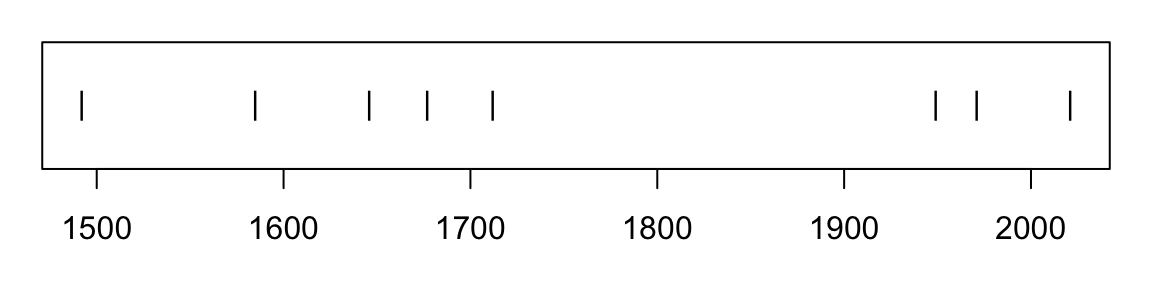

In [ ]:
par(mar = c(3, 1, 1, 1) + 0.1)
plot(eruptions, rep(0, n_eruptions), 
  pch = "|", axes = FALSE)
axis(1)
box()

In [ ]:
avg_years_between_eruptions <- mean(diff(eruptions[-n_eruptions]))
avg_years_between_eruptions

[1] 79.83333

Based on data up to and including 1971, eruptions on La Palma happen every 79.8 years on average.

Studies of the magma systems feeding the volcano, such as @marrero2019, have proposed that there are two main magma reservoirs feeding the Cumbre Vieja volcano; one in the mantle (30-40km depth) which charges and in turn feeds a shallower crustal reservoir (10-20km depth).

Eight eruptions have been recorded since the late 1400s (@fig-timeline).

Data and methods are discussed in @sec-data-methods.

Let $x$ denote the number of eruptions in a year. Then, $x$ can be modeled by a Poisson distribution

$$
p(x) = \frac{e^{-\lambda} \lambda^{x}}{x !}
$$ {#eq-poisson}

where $\lambda$ is the rate of eruptions per year. Using @eq-poisson, the probability of an eruption in the next $t$ years can be calculated.

| Name                | Year |
|---------------------|------|
| Current             | 2021 |
| Teneguía            | 1971 |
| Nambroque           | 1949 |
| El Charco           | 1712 |
| Volcán San Antonio  | 1677 |
| Volcán San Martin   | 1646 |
| Tajuya near El Paso | 1585 |
| Montaña Quemada     | 1492 |

@tbl-history summarises the eruptions recorded since the colonization of the islands by Europeans in the late 1400s.

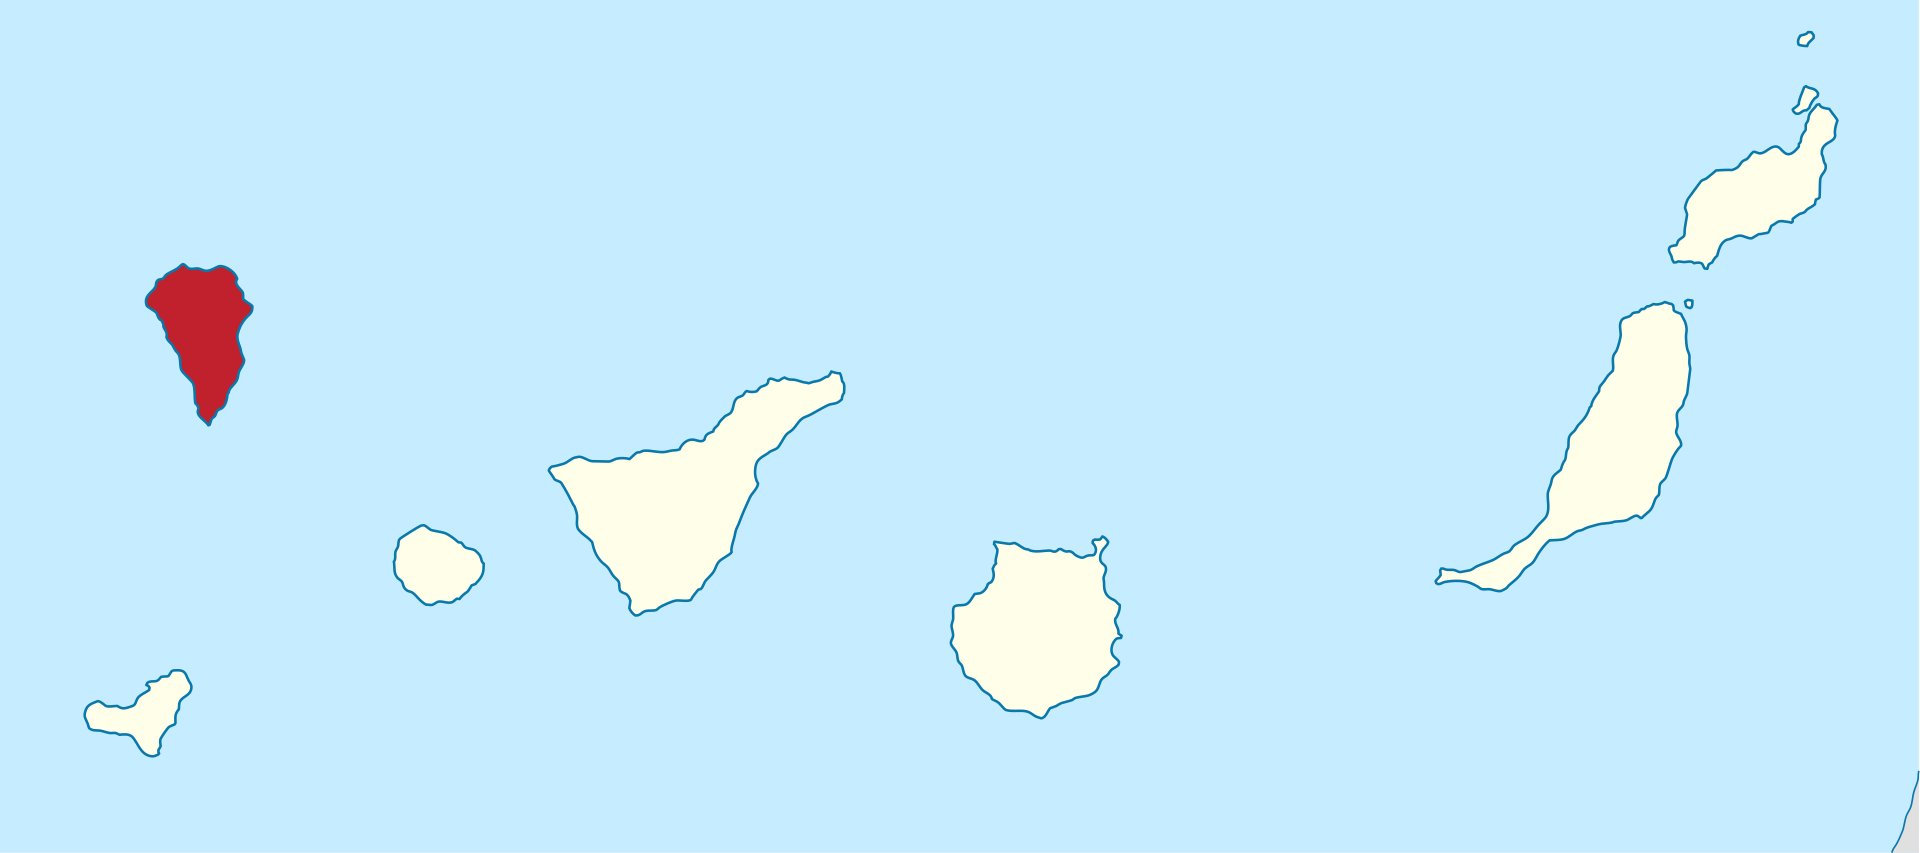{#fig-map }

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands (@fig-map).

## Data & Methods

## Conclusion

## References